In [1]:
%load_ext autoreload

In [3]:
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, truncnorm, uniform
from statsmodels.tsa.api import VAR
import sys
from tqdm.auto import tqdm

sys.path.append('../../..')
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from nld_utils import simulate_baier_klein, simulate_double_pendulum, simulate_lorenz, simulate_rossler

# Set Up Oscillations About a Point

In [105]:
T = 100 # s, duration of time series
dt = 0.001 # s, time step
d = 10 # dimensions
mu = 0
sigma = 2

pts = np.random.normal(loc=mu, scale=sigma, size=(d,))
pts = np.repeat(pts[np.newaxis, :], int(T/dt), axis=0)

In [119]:
freqs = [1]
amps = [0.5]
phase_sigmas = [np.pi*0.05]
# freqs = [1, 35]
# amps = [0.5, 0.25]
# phase_sigmas = [np.pi/2, np.pi/2]
# freqs = [100]
# amps = [0.3]
# phase_sigmas = [np.pi/2]


for freq, amp, phase_sigma in zip(freqs, amps, phase_sigmas):
    freq_content = np.zeros(pts.shape)
#     dist = truncnorm(a=-3, b=3, loc=0, scale=phase_sigma/3)
#     dist = uniform(loc=-phase_sigma, scale=2*phase_sigma)
    dist = norm(loc=0, scale=phase_sigma)
    for i in range(pts.shape[1]):
        if phase_sigma == 0:
            phase = 0
        else:
            u = np.random.uniform()
            phase = dist.ppf(u)
        freq_content[:, i] = amp*np.cos(np.arange(pts.shape[0])*dt*2*np.pi*freq + phase)

        pts[:, i] += freq_content[:, i]
    

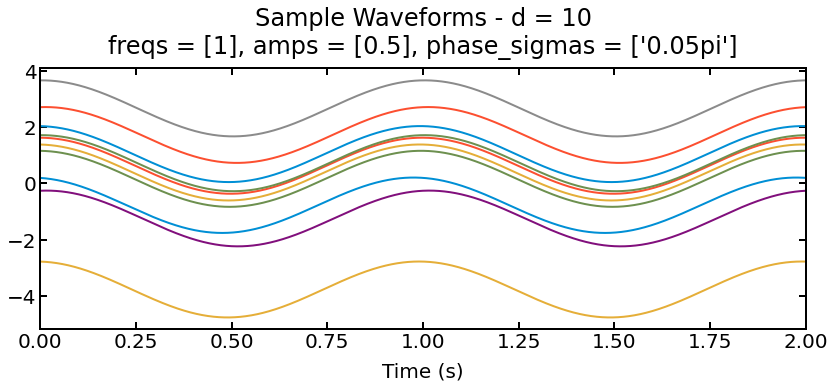

In [120]:
plt.style.use('../../sci_style.py')
num_samples = 10
indices = np.random.choice(np.arange(pts.shape[1]), size=(num_samples,), replace=False)
# fig, axs = plt.subplots(2, 2, figsize=(12, 5))
plt.figure(figsize=(12, 5))
for num, i in enumerate(indices):
#     ax = axs[int(num/2)][num % 2]
#     ax.plot(np.arange(pts.shape[0])*dt, pts[:, i])
#     ax.set_title(f'dim {i}')
#     ax.set_xlabel('Time (s)')
#     ax.set_xlim([0, 2])
    plt.plot(np.arange(pts.shape[0])*dt, pts[:, i], label=f'dim {i}')
plt.xlabel('Time (s)')
plt.xlim([0, 2])
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
ps_strings = [f'{ps/np.pi:.2f}' + r'pi' for ps in phase_sigmas]
plt.title(f"Sample Waveforms - d = {d}\nfreqs = {freqs}, amps = {amps}, phase_sigmas = {ps_strings}")
plt.show()

# VAR Grid Search

In [121]:
data = pts.copy()

In [122]:
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.1, 0.5)]
# windows = np.hstack([np.arange(0.05, 0.101, 0.01), [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])
# windows = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5]
max_lag = 15
lags = np.arange(1, max_lag + 1)
T_pred = 25
num_window_samples = 10

In [123]:
grid_search_df = []
iterator = tqdm(total = len(windows)*len(lags))
for window in windows:
    stride = window
    min_ind = int(0/stride)
    max_ind = int((data.shape[0]*dt - window - T_pred*dt)/stride)
    possible_inds = np.arange(min_ind, max_ind + 1)
    window_inds = np.random.choice(possible_inds, size=(np.min([num_window_samples, len(possible_inds)])), replace=False)
#     num_windows = int(np.floor((data.shape[0]-window)/stride)+1)
    for p in lags:
#         for i in range(num_windows):
        for i in window_inds:
            start_ind = i*int(stride/dt)
            start_time = i*stride
            end_ind = i*int(stride/dt) + int(window/dt)
            end_time = i*stride + window
            if end_ind + T_pred <= data.shape[0]:
                
                window_data = data[start_ind:end_ind]
                results = compute_VAR_p(window_data, p)
                test_data = data[end_ind - p:end_ind + T_pred]

                train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
                train_mse = ((train_prediction - train_true_vals)**2).mean()
                test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
                test_mse = ((test_prediction - test_true_vals)**2).mean()
                persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

                # ADD TO DICTIONARY
                results['train_mse'] = train_mse
                results['test_mse'] = test_mse
                results['persistence_baseline'] = persistence_baseline

                # ADD TIMESTAMPS
                results['start_ind'] = start_ind
                results['end_ind'] = end_ind
                results['start_time'] = start_time
                results['end_time'] = end_time

                # ADD PARAMETERS
                results['window'] = window
                results['stride'] = stride
                results['p'] = p
                results['T_pred'] = T_pred
                
                grid_search_df.append(results)
        iterator.update()
iterator.close()
grid_search_df = pd.DataFrame(grid_search_df)

  0%|          | 0/300 [00:00<?, ?it/s]

In [124]:
test_mse_mat = np.zeros((len(windows), len(lags)))
for i, window in enumerate(windows):
    for j, p in enumerate(lags):
        test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()

In [125]:
def pick_2d_optimum(mat, thresh=0.95):
    true_min = mat.min()
    i_vals, j_vals = np.where(mat*thresh - true_min <= 0)
    selected_i = np.min(i_vals)
    selected_j = np.min(j_vals[i_vals == selected_i])
    selected_i, selected_j

    return selected_i, selected_j
thresh = 1
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)

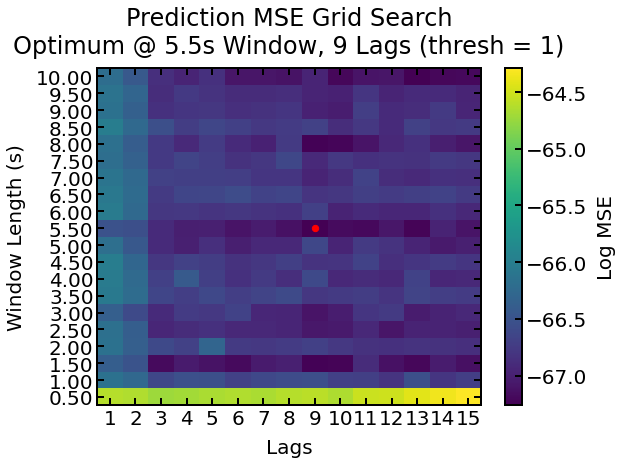

In [126]:
log_test_mse_mat = np.log(test_mse_mat)
plt.style.use('../../sci_style.py')
plt.figure(figsize=(9, 6))
# norm = colors.TwoSlopeNorm(vmin=test_mse_mat.min(), vcenter=test_mse_mat.mean(), vmax=test_mse_mat.max())
# plt.pcolormesh(test_mse_mat, norm=norm)
plt.pcolormesh(log_test_mse_mat)
plt.xticks(np.arange(0, max_lag) + 0.5, [lags[i] for i in np.arange(0, max_lag)])
plt.yticks(np.arange(0, len(windows)) + 0.5, [f"{windows[i]:.2f}" for i in np.arange(0, len(windows))])
plt.xlabel('Lags')
plt.ylabel('Window Length (s)')
cbar = plt.colorbar(label='Log MSE')
# cbar_ticks = [norm.vmin + t*(norm.vcenter-norm.vmin) for t in np.arange(0, 1.1, 0.2)]
# cbar_ticks += [norm.vcenter + t*(norm.vmax-norm.vcenter) for t in np.arange(0, 1.1, 0.2)]
# cbar.set_ticks(cbar_ticks)
plt.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()
plt.title(f"Prediction MSE Grid Search\nOptimum @ {windows[w_ind]}s Window, {lags[p_ind]} Lags (thresh = {thresh})")
plt.show()

# Compute VAR Results

In [127]:
window = windows[w_ind]
p = lags[p_ind]

In [128]:
VAR_results = []
stride = window
num_windows = int(np.floor((data.shape[0]-int(window/dt))/int(stride/dt)+1))
for i in tqdm(range(num_windows)):
    start_ind = i*int(stride/dt)
    start_time = i*stride
    end_ind = i*int(stride/dt) + int(window/dt)
    end_time = i*stride + window
    if end_ind + T_pred <= data.shape[0]:

        window_data = data[start_ind:end_ind]
        results = compute_VAR_p(window_data, p)
        test_data = data[end_ind - p:end_ind + T_pred]

        train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
        train_mse = ((train_prediction - train_true_vals)**2).mean()
        test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
        test_mse = ((test_prediction - test_true_vals)**2).mean()
        persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

        # ADD TO DICTIONARY
        results['train_mse'] = train_mse
        results['test_mse'] = test_mse
        results['persistence_baseline'] = persistence_baseline

        # ADD TIMESTAMPS
        results['start_ind'] = start_ind
        results['end_ind'] = end_ind
        results['start_time'] = start_time
        results['end_time'] = end_time

        # ADD PARAMETERS
        results['window'] = window
        results['stride'] = stride
        results['p'] = p
        results['T_pred'] = T_pred

        VAR_results.append(results)
VAR_results = pd.DataFrame(VAR_results)

  0%|          | 0/18 [00:00<?, ?it/s]

In [129]:
# VAR_results = grid_search_df[np.logical_and(grid_search_df.window == windows[w_ind], grid_search_df.p == lags[p_ind])]

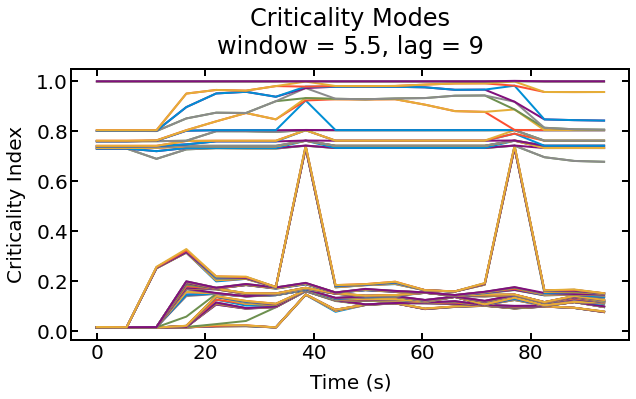

In [130]:
# plot mode criticalities
mode_criticalities = np.zeros((len(VAR_results), len(VAR_results.criticality_inds.iloc[0])))
for i, row in VAR_results.iterrows():
    mode_criticalities[i] = np.sort(row.criticality_inds)

for i in range(len(VAR_results.criticality_inds.iloc[0])):
    plt.plot(VAR_results.start_time, mode_criticalities[:, i])
plt.xlabel('Time (s)')
plt.ylabel('Criticality Index')
plt.title(f"Criticality Modes\nwindow = {window}, lag = {p}")
plt.show()

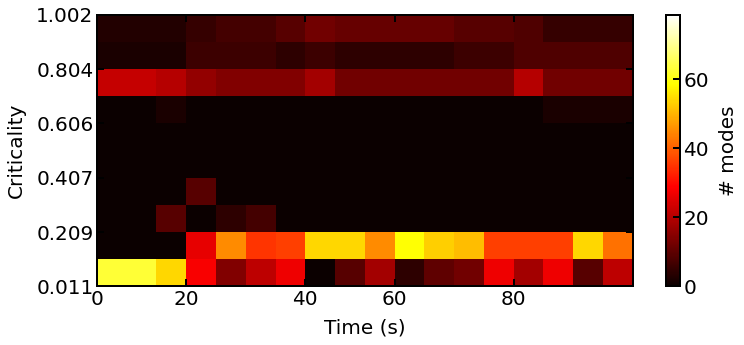

In [131]:
bin_nums = 10
bin_min = np.concatenate(VAR_results.criticality_inds.to_numpy()).min()
bin_max = np.concatenate(VAR_results.criticality_inds.to_numpy()).max()
bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
for t in range(VAR_results.criticality_inds.shape[0]):
    criticality_prob_dist[t] = np.histogram(VAR_results.criticality_inds[t], bins=bins)[0]
start_times = np.arange(VAR_results.criticality_inds.shape[0])*stride/60
T_max = VAR_results.criticality_inds.shape[0]*stride
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
im = plt.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
ax.set_xticks([int(i/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
ax.set_yticks(np.arange(0, bin_nums + 1, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
cb = fig.colorbar(im, ax=ax)
cb.set_label(label='# modes')
plt.xlabel("Time (s)")
plt.ylabel("Criticality")
plt.show()

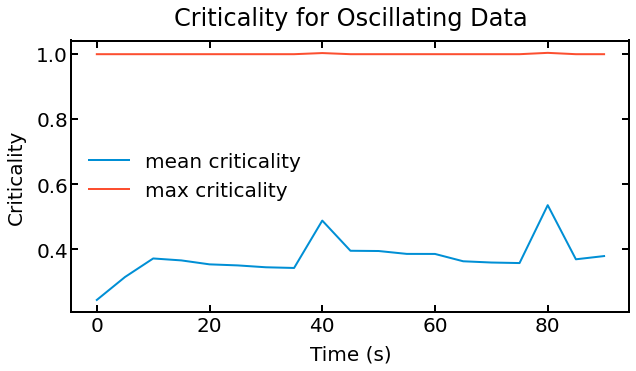

In [99]:
plt.plot(VAR_results.start_time, VAR_results.criticality_inds.apply(lambda x: x.mean()), label='mean criticality')
plt.plot(VAR_results.start_time, VAR_results.criticality_inds.apply(lambda x: x.max()), label='max criticality')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Criticality')
plt.title("Criticality for Oscillating Data")
plt.show()

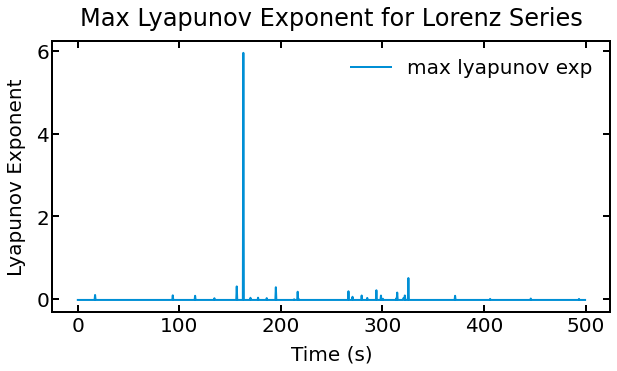

In [133]:
lyapunov_exps = VAR_results.eigs.apply(lambda x: np.real(x - np.ones(len(x)))/dt)
# plt.plot(VAR_results.start_time, [x.mean() for x in lyapunov_exps], label='mean criticality')
plt.plot(VAR_results.start_time, [x.max() for x in lyapunov_exps], label='max lyapunov exp')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Lyapunov Exponent')
plt.title("Max Lyapunov Exponent for Lorenz Series")
plt.show()

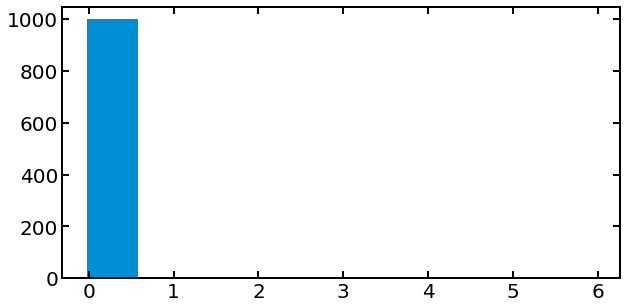

In [134]:
plt.hist([x.max() for x in lyapunov_exps], bins=10)
plt.show()

# NLD Methods?

In [116]:
def estimate_stability_using_particle(
    js: np.ndarray, p: int, test_eigenvectors=False
) -> np.ndarray:

    """Estimate maximal lyapunov exponent given a sequence of Jacobians using the technique of ___.
    Push a random unit vector through the sequence and measure the deformation."

    Args:
        js (np.ndarray): Sequence of Jacobians, stored in a multi-dimensional array.
        p (int): Number of random unit vectors to  use.

    Returns:
        lams: p-dimensional array containing estimates of maximal Lyapunov exponent.
    """

    K, N = js.shape[0], js.shape[1]

    # generate p vectors on the unit sphere in R^n
    U = np.random.randn(N, p)
    U /= np.linalg.norm(U, axis=0)

    if test_eigenvectors:
        # generate p vectors along the eigenvectors of js[0]
        eig_vals, eig_vecs = np.linalg.eig(js[0])
        ind_max_eig = np.argmax(np.abs(eig_vals))
        leading_eig_vec = np.real(eig_vecs[:, 0])
        random_scalings = np.random.normal(0, 1, p)
        U = leading_eig_vec[:, None] * random_scalings + np.random.normal(
            0, 0.001, (N, p)
        )
        U /= np.linalg.norm(U, axis=0)

    # preallocate memory for lyapunov exponents
    lams = np.zeros(p)

    for k in tqdm(range(K)):

        # push U through jacobian at time t
        U = js[k] @ U

        # measure deformation and store log
        lams += np.log(np.linalg.norm(U, axis=0))

        # renormalize U
        U /= np.linalg.norm(U, axis=0)

    # average by number time steps to get lyapunov exponent estimates
    lams /= K

    return lams

In [117]:
def compute_A_mat(coefs):
    N = coefs.shape[1]
    p = coefs.shape[0]
    A_mat = np.zeros((N*p, N*p))
    for i in range(p):
        A_mat[0:N][:, i*N:(i+1)*N] = coefs[i]
    
    for i in range(p - 1):
        A_mat[(i + 1)*N:(i + 2)*N][:, i*N:(i + 1)*N] = np.eye(N)
    
    return A_mat

In [118]:
VAR_results = VAR_results.sort_values('start_time')

In [119]:
js = []
for i, row in VAR_results.iterrows():
    js.extend(np.repeat(compute_A_mat(row.coefs)[None,:], row.window/dt, axis=0))

In [120]:
lams = estimate_stability_using_particle(np.array(js), 100, test_eigenvectors=False)

  0%|          | 0/913000 [00:00<?, ?it/s]

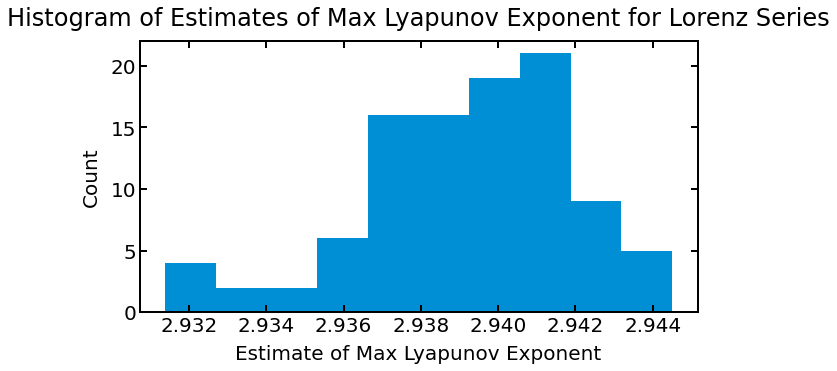

In [121]:
plt.hist(lams/dt)
plt.title("Histogram of Estimates of Max Lyapunov Exponent for Lorenz Series")
plt.xlabel("Estimate of Max Lyapunov Exponent")
plt.ylabel("Count")
plt.show()